Phase shift extraction code from interference data

Imports and adding path

In [1]:
# add path:
import sys
# sys.append(r"C:\Users\User\z\Desktop\WUT\Diplomka\ZPRACOVÁNÍ\Data testing\processing_project")
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..')) # Go up two levels from current path (from src/ to project root)
sys.path.append(project_root)
# add my library:
import global_utils
import constants
print(constants.__file__)
import global_functions_im
import utils
import functions_image_crop
import functions_phase_shift
import functions_abel
# run this command to install all requirements:
#       pip install -r project_abel/requirements.txt
#       for pyAble a lower version of python is needed
# ------- miscellaneous imports: -------
import matplotlib.pyplot as plt
import tifffile as tiff # Loads .tiff as a NumPy array
import numpy as np # low level image manipulation (matrix)
import cmasher as cmr # extra colormaps
# from cmap import Colormap
# from scipy.ndimage import gaussian_filter1d
# from scipy.signal import correlate
# from skimage.feature import peak_local_max
# from skimage.restoration import unwrap_phase
from scipy.ndimage import gaussian_filter
# import abel
# ------- enables interactive window plot ---------
# %matplotlib notebook

C:\Users\User\z\Desktop\WUT\Diplomka\ZPRACOVÁNÍ\Data testing\processing_project\constants.py


Choosing path

In [2]:
path = constants.base_dir
folders = global_utils.get_folder_names(path)
folders2 = global_utils.get_folder_names(os.path.join(path, folders[1]))
folders3 = global_utils.get_folder_names(os.path.join(path, folders[1], folders2[1]))
path4 = os.path.join(path, folders[1], folders2[1], folders3[0])
folders4 = global_utils.get_folder_names(path4)
print(folders)
print(folders2)
print(folders3)
print(folders4)
# files
print("--- Files ---")
# path_img_files = os.path.join(path4, folders4[1])
# files_img = global_utils.get_file_names(path_img_files)
# path_ref_files = os.path.join(path4, folders4[9])
# files_ref = global_utils.get_file_names(path_ref_files)
# image path creation
# img_path = os.path.join(path_img_files, files_img[85]) # 85 - H0_3_28_25\(2) 1000 - 2000 ns\M7_X10.tif
# ref_path = os.path.join(path_ref_files, files_ref[19]) # 19 - H0_3_28_25\reference x4\REF_X9.tif

# ------ 2090 nm ------
path_img_files = os.path.join(path4, folders4[1])
files_img = global_utils.get_file_names(path_img_files)
img_path = os.path.join(path_img_files, files_img[0]) # 
path_ref_files = os.path.join(path, folders[1], folders2[1], folders3[9])
files_ref = global_utils.get_file_names(path_ref_files)
ref_path = os.path.join(path_ref_files, files_ref[1]) # 


# --- x2 ---
# files_img = global_utils.get_file_names(path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[2])
# img_path = path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[2] + "\\" + files_img[0]
# files_ref = global_utils.get_file_names(path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[8])
# ref_path = path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[8] + "\\" + files_ref[1]
# 1x ------
# files_img = global_utils.get_file_names(path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[6])
# img_path = path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[6] + "\\" + files_img[0]
# files_ref = global_utils.get_file_names(path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[7])
# ref_path = path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[7] + "\\" + files_ref[1]
print(img_path)
print(ref_path)

['IDEA program+ cvicna data', 'Images', 'Spectra']
['1064 nm', '2090 nm']
['Cu', 'H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'ref x4 Cu, 1-2us', 'ref x4 Cu,H0-H2,H6 - 50-1000ns', 'ref x4 H0, 1-2us', 'ref x4 H1, 1-2us', 'ref x4 H2, 1-2us', 'ref x4 H3,H4 1-2us', 'ref x4 H3-H5, 50-1000ns + H5 1-2us', 'ref x4 H6, 1-2us', 'wrong']
['(1) 50-1000ns', '(2) 1000-2000ns', '(3) 2-5us', '(4) 5-15us', '(5) 15-100us', '(6) 100us-2ms', 'reference x1', 'reference x2', 'reference x4']
--- Files ---
C:\Users\User\z\Desktop\WUT\Diplomka\DATA\Images\2090 nm\Cu\(2) 1000-2000ns\M10_X1.tif
C:\Users\User\z\Desktop\WUT\Diplomka\DATA\Images\2090 nm\ref x4 Cu,H0-H2,H6 - 50-1000ns\REFx4_X10.tif


Loading practice data

In [3]:
img = tiff.imread(img_path)
ref = tiff.imread(ref_path)

colormap = cmr.nuclear
# global_functions_im.plot_two_images(img, ref, title1='raw Image', title2='raw Reference',cmap=colormap)
# global_functions_im.plot_two_images(img, ref, title1='raw Image', title2='raw Reference',cmap=colormap)

Auto crop function with a constant size for:
x4: 721 px - 40 px
x2: 433 px - 20 px
x1: 235 px - 20 px

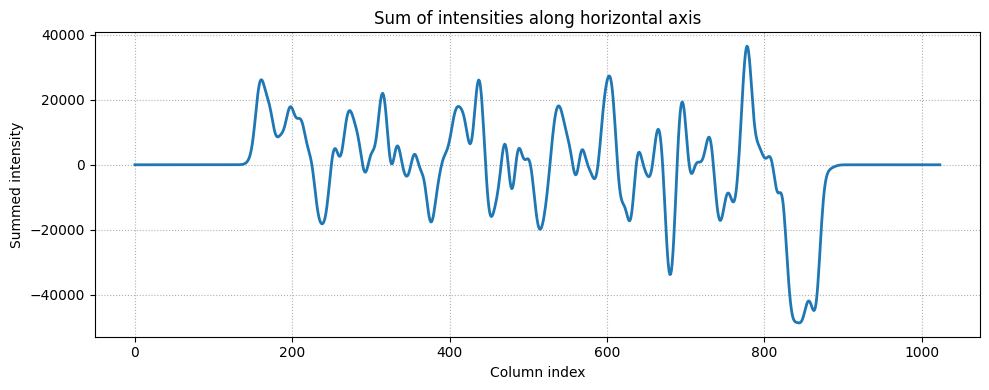

489
512
151 874
683


In [4]:
profile1 = functions_image_crop.get_horizontal_intensity_sum(img)
# utils.plot_intensity(profile1)
smoothed1 = functions_image_crop.smooth_profile(profile1, sigma = 5)
# utils.plot_intensity(smoothed1)
grad1 = functions_image_crop.calculate_1d_gradient(profile1, sigma = 5)
utils.plot_1d_profile(grad1,title='Sum of intensities along horizontal axis',xlabel='Column index',ylabel='Summed intensity')
center1 = functions_image_crop.center_by_symmetry_1d(profile1, smoothing_sigma=10)
print(center1)
# detect edges
l, r = functions_image_crop.detect_edges(profile1, smoothing_sigma=6, threshold_ratio=0.3)
# now you can compute the center or feed l and r into a crop function
print((l + r) // 2) 
print(l,r)
# crop
sx = (l + r) // 2
wid = r - l - 40 # r - l - #px
print(wid)
hei = img.shape[0]
crop_img = functions_image_crop.crop_from_center(img, sx, wid, hei)
crop_ref = functions_image_crop.crop_from_center(ref, sx, wid, hei)
colormap = cmr.nuclear
#
# global_functions_im.plot_two_images(crop_img, crop_ref, title1='crop Image', title2='crop Reference',cmap=colormap)

Padding image

In [5]:
p = 15
padded_img = np.pad(crop_img, pad_width = p, mode = 'constant') # constant, wrap, symmetric
padded_ref = np.pad(crop_ref, pad_width = p, mode = 'constant') # constant, wrap, symmetric
# global_functions_im.plot_two_images(padded_img, padded_ref, title1='crop padded Image', title2='crop padded Reference',cmap=colormap)

Fourier transform visualisation

In [6]:
# utils.plot_fft_spectra(padded_img, cmap_mag = 'gray')
# utils.plot_fft_spectra(padded_ref)

Fourier transform - automatic phase extraction pt1
1. Function for FFT
2. Function to find diffraction peaks
3. Function for elliptical mask
4. Extract phase

{'center': (142, 356), 'plus1': (np.int64(119), np.int64(357)), 'minus1': (np.int64(165), np.int64(355))}
22


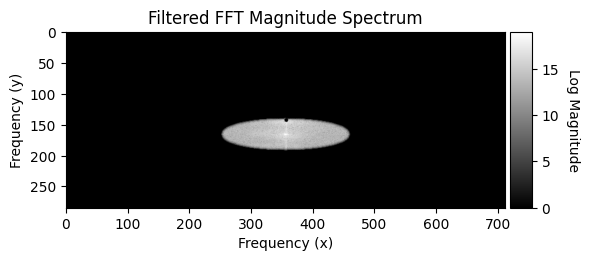

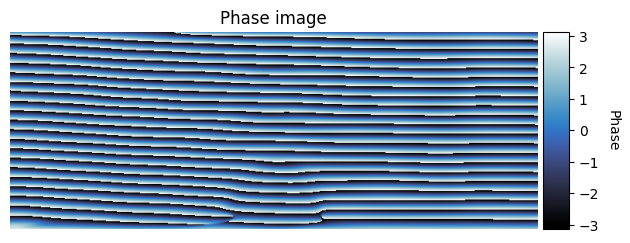

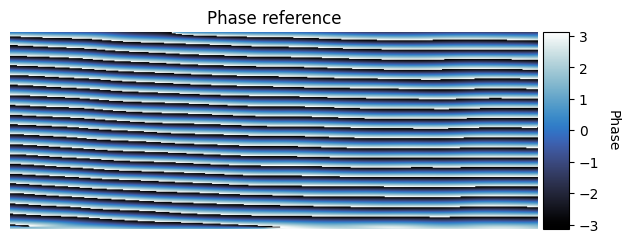

In [7]:
def compute_phase_from_padded(
    img_padded: np.ndarray,
    order: str = 'plus1',
    exclude_radius: int = 10,
    smooth_sigma: float = 0.0,
    a_div: int = 9,
    b_div: int = 9,
    mask_sigma: float = 0.0,
    pad: int = 0
) -> np.ndarray:
    """
    Locate a given Fourier peak in a zero-padded image (using simple top-two method),
    build an elliptical mask around it, and extract the phase image.

    Parameters
    ----------
    img_padded : 2D ndarray
        Zero-padded input image.
    order : {'center','plus1','minus1'}
        Which peak to isolate.
    exclude_radius : int
        Radius around DC to mask out before picking peaks.
    smooth_sigma : float
        Gaussian sigma for pre-peak FFT-magnitude smoothing.
    a_div, b_div : int
        Divisors for ellipse semi-axes: a = cols//a_div, b = rows//b_div.
    mask_sigma : float
        If >0, Gaussian-smooth the binary mask by this sigma.
    pad : int
        Number of pixels of padding on each side to remove from the output.

    Returns
    -------
    phase_image : 2D ndarray
        Phase of the inverse FFT of the masked Fourier component,
        cropped to original size if pad>0.
    """
    coords = functions_phase_shift.find_fourier_peaks(
        img=img_padded,
        exclude_radius=exclude_radius,
        smooth_sigma=smooth_sigma
    )
    y0, x0 = coords[order]
    rows, cols = img_padded.shape
    a = cols // a_div
    b = rows // b_div
    mask = functions_phase_shift.create_ellipse_mask(
        shape=(rows, cols),
        x_center=x0,
        y_center=y0,
        a=a,
        b=b,
        sigma=mask_sigma
    )
    return functions_phase_shift.extract_phase_from_mask_v2(
        img_padded=img_padded,
        mask=mask,
        peak_coord=(y0, x0),
        pad=pad,
        inner_radius_mask = 3
    )


# isolate the +1st-order peak and get its phase map
spectr_peaks = functions_phase_shift.find_fourier_peaks(padded_img,exclude_radius = 8,smooth_sigma=1.0)
print(spectr_peaks)
# extract the first coordinate of ‘center’ and ‘plus1’
peak_name = 'minus1'  # or 'plus1', or 'minus1'

if peak_name == 'plus1':
    y_peak = int(spectr_peaks['plus1'][0])
    x_peak = int(spectr_peaks['plus1'][1])
elif peak_name == 'minus1':
    y_peak = int(spectr_peaks['minus1'][0])
    x_peak = int(spectr_peaks['minus1'][1])
else:
    raise ValueError(f"Unknown peak_name: {peak_name!r}")

y_peak_c = int(spectr_peaks['center'][0])
x_peak_c = int(spectr_peaks['center'][1])

spectr_peak_distance = abs(y_peak_c - y_peak) - 1
print(spectr_peak_distance)
# y_peak= y_peak - 15
# plot masked spectra
a = 100
b = spectr_peak_distance
rows, cols = padded_img.shape
maskino_spectrino = functions_phase_shift.create_ellipse_mask(
        shape=(rows, cols),
        x_center=x_peak,
        y_center=y_peak,
        a= a,
        b= b,
        sigma=1
    )
maskino_spectrino_center = functions_phase_shift.circular_exclusion_mask(
    shape=(rows, cols),
    center=(y_peak_c,x_peak_c),
    radius=3
)

# inferno_cmap = plt.get_cmap('gray')  # this is the Colormap instance
# global_functions_im.plot_image(maskino_spectrino_center, cmap=cmr.cosmic)
fig = utils.plot_filtered_fft_spectrum(img_padded=padded_img, mask=maskino_spectrino, extra_mask=maskino_spectrino_center)
# -----
phase_map_im = compute_phase_from_padded(
    img_padded=padded_img,
    order=peak_name,
    exclude_radius=8,
    smooth_sigma=2,
    a_div=a,
    b_div=b,
    mask_sigma=1,
    pad = p
)
phase_map_ref = compute_phase_from_padded(
    img_padded=padded_ref,
    order=peak_name,
    exclude_radius=8,
    smooth_sigma=2,
    a_div=a,
    b_div=b,
    mask_sigma=1,
    pad = p
)
# Colormap('cmap:red')
fig = global_functions_im.plot_image(phase_map_im, title='Phase image', cmap=cmr.arctic, colorbar_label='Phase') # arctic
fig = global_functions_im.plot_image(phase_map_ref, title='Phase reference', cmap=cmr.arctic, colorbar_label='Phase') # arctic
# global_utils.save_plot_as_png(r'C:\Users\User\z\Desktop\WUT\Diplomka\ZPRACOVÁNÍ\Data testing\processing_project\Abel-inversion\output\phase_a100_b30_sgm_1(2).png', fig)

Phase shift + crop bottom

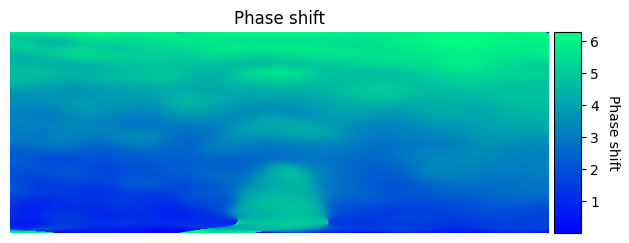

In [8]:
phase_shift = phase_map_ref - phase_map_im
phase_shift = np.mod(phase_shift, 2 * np.pi) # modulo 2pi

fig = global_functions_im.plot_image(phase_shift, title='Phase shift', cmap='winter',colorbar_label='Phase shift') # arctic
# global_utils.save_plot_as_png(r'C:\Users\User\z\Desktop\WUT\Diplomka\ZPRACOVÁNÍ\Data testing\processing_project\Abel-inversion\output\phaseshift_a100_b15_sgm_1.png', fig)

Crop base + Phase unwrap + Mask phase unwrap

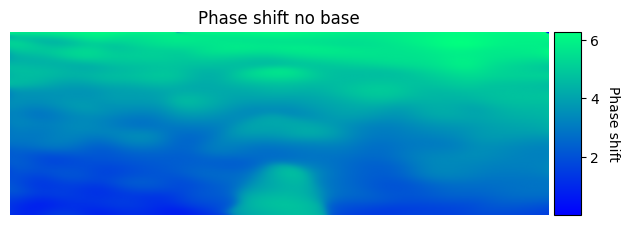

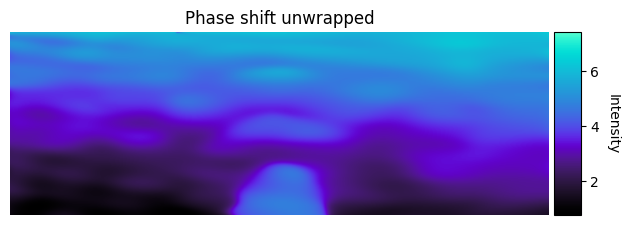

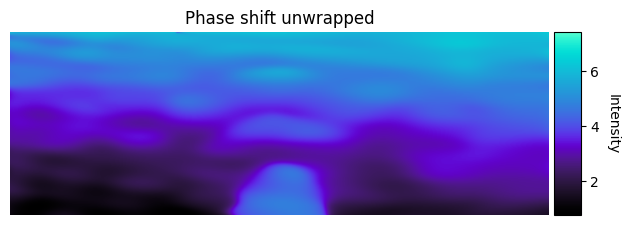

In [9]:
## --- CROP base ---
num_crop_2090_H0 = 23
phase_shift_crop = functions_phase_shift.crop_img_base(phase_shift, num_crop_2090_H0)
fig = global_functions_im.plot_image(phase_shift_crop, title='Phase shift no base', cmap='winter',colorbar_label='Phase shift') # arctic
## --- Phase UNWRAP with step function algorithms ---
# openCV library
# image_unwrapped = unwrap_phase(phase_shift, wrap_around=(False, False))
# image_unwrapped = np.unwrap(np.unwrap(phase_shift, axis=0), axis=1)
from skimage.restoration import unwrap_phase
image_unwrapped = unwrap_phase(phase_shift_crop)
global_functions_im.plot_image(image_unwrapped, title='Phase shift unwrapped', cmap=cmr.cosmic) # prinsenvlag, iceburn, redshift
# global_functions_im.save_tiff(image_unwrapped, r"C:\Users\User\z\Desktop\WUT\Diplomka\ZPRACOVÁNÍ\Data testing\processing_project\Abel-inversion\output\random_test.jpg")
# wrapped_phase is your 2D numpy array in (−π,π]
#mage_unwrapped = pywrap.unwrap_branch_cut(phase_shift)
# or for the Poisson solver
#unwrapped_ls = pywrap.unwrap_least_squares(phase_shift)
#plot_image(image_unwrapped, title='Phase shift', cmap=cmr.redshift) # prinsenvlag, iceburn, redshift

Now we select a single row and make an Abel transform. However before that the data needs to get pre-processed. This can go few different ways.
1. Everything where (r > R) = 0 -> masking out the plasma
2. Using PyAbel library - I need to symmetrize the data by:
a) remove linear tilt: subtract a best‐fit straight line from that 1D signal to correct any sloping background.
b) Average Left and Right: enforce perfect symmetry about the chosen centre by replacing each pair of equidistant points with their average.
-- OR --
a) Use 1D fourier transform: you can enforce even symmetry by projecting out the odd component in the transform domain. For any 1D real signal h(x), its Fourier transform H(k)=F{h}(k) can be split into H(k)=H(k)_even + iH(k)_odd where H(k)_even =ℜ{H(k)}. The inverse transform of just the real part gives you the even (symmetric) component.
-- OR --
a) Fourier-Hankel transform
b) zero padding needed
3. Abel transform
I need to check which algorithm is the best for the job.

232 682
340
341


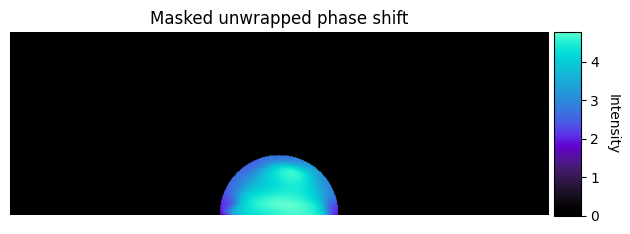

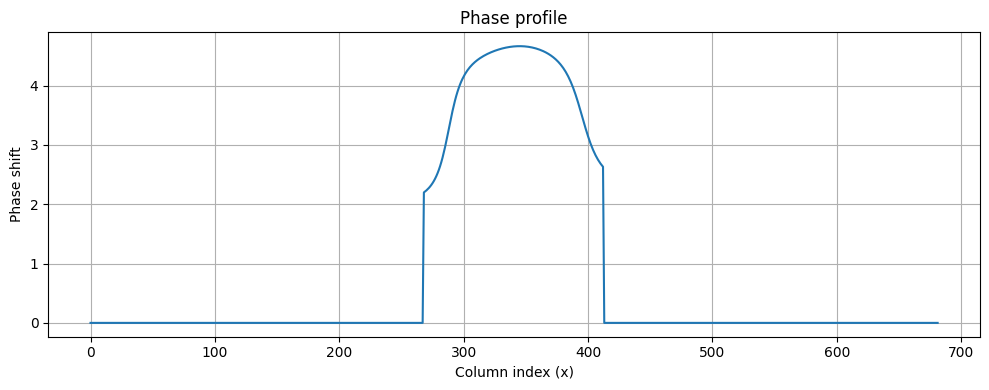

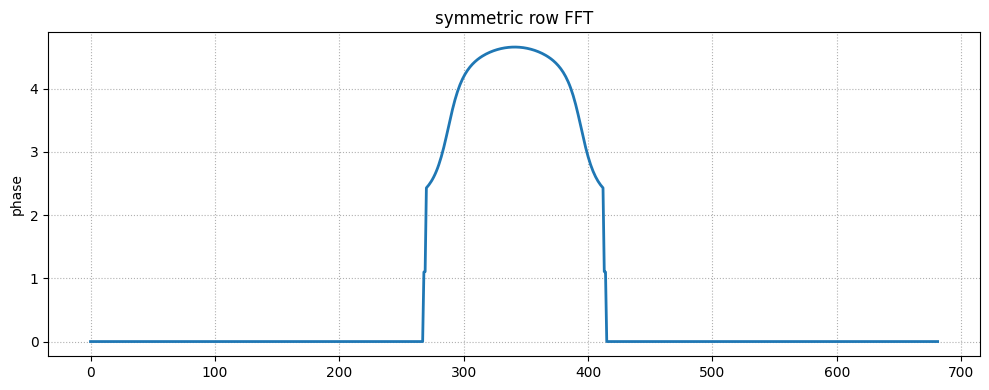

In [10]:
## --- 1. Mask plasma ---
rows, cols = image_unwrapped.shape
mask_radius_2090_H0 = 75
# y0 at the last row (base of the image), x0 at the horizontal midpoint
center_x = 340
y0 = rows - 1
x0 = cols // 2 # middle of an image
print(rows, cols)
print(center_x)
print(x0)
semicircle_mask = functions_abel.make_semicircle_mask((rows, cols),
                         center = (y0, center_x),
                         radius =  mask_radius_2090_H0,
                         smooth_sigma = 0.01)
masked_plasma = image_unwrapped * semicircle_mask
global_functions_im.plot_image(masked_plasma, title='Masked unwrapped phase shift', cmap=cmr.cosmic)

## --- 2. Symmetrization ---
def plot_image_row(img: np.ndarray, row: int, title: str = None) -> None:
    """
    Plot the intensity profile of a single row of a 2D image.

    Parameters
    ----------
    img : 2D ndarray
        Input image (rows = height, cols = width).
    row : int
        Zero-based index of the row to plot (vertical coordinate).
    title : str, optional
        Plot title.
    """
    profile = img[row, :]            # grab the row (y = row, all x)
    plt.figure(figsize=(10, 4))
    plt.plot(profile)
    if title:
        plt.title(title)
    plt.xlabel("Column index (x)")
    plt.ylabel("Phase shift")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

row = y0 - 20
plot_image_row(masked_plasma, row= row, title="Phase profile")

## --- (A) 1D fourier transform ---
symmetric_row_FFT = functions_abel.symmetrize_via_fft(masked_plasma[row, :])
utils.plot_1d_profile(symmetric_row_FFT,title='symmetric row FFT',xlabel='',ylabel='phase')

## --- (B) Remove linear tilt, average left and right  ---
# remove_tilt = functions_abel.remove_linear_tilt(masked_plasma[row, :])
# utils.plot_intensity(remove_tilt) 
# symmetric_row = functions_abel.symmetrize_profile(
#        remove_tilt,
#        side = "both"
# )
# utils.plot_intensity(symmetric_row) 

Abel transform: Fourier-Hankel method -> nope, doesn't work easily

# a toy Gaussian “projection”
sigma = 10.0
x     = np.linspace(-100, 100, 1024)
dx    = x[1] - x[0]
profile = np.exp(-x**2 / (2*sigma**2))

# invert
dr = dx
# profile = symmetric_row_FFT
r, f_rec = functions_abel.abel_inverse_fourier_hankel(profile, dx, dr, nu=0)

# r is your radial grid, f_reconstructed is the recovered f(r)
utils.plot_intensity(r)

# Abel transform 1D
methods in PyAbel package

682
341
341
Loading basis sets...
Updating regularization...
Calculating correction...


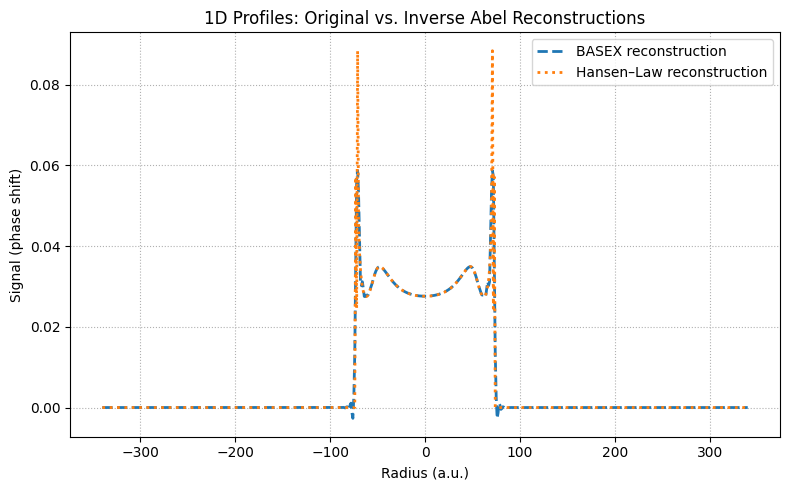

In [11]:
# --- crop data in the axis of symmetry ---
# (or, if your axis isn’t exactly the midpoint, find it by some feature:)
c1 = symmetric_row_FFT.argmax()
c2 = symmetric_row_FFT.size // 2
print(symmetric_row_FFT.size) # 232 x 682
print(c1)
print(c2) # integer‐division midpoint as symmetry column

# 1D data:
half_profile = symmetric_row_FFT[c1:]

# Now run the inverse‐Abel on that half-profile:
dr = 1
inv_basex = functions_abel.inverse_abel(half_profile, method = 'basex', dr = dr)
inv_hansenlaw = functions_abel.inverse_abel(half_profile, method = 'hansenlaw', dr = dr)

# 1) build the half-axis
r_half = np.arange(half_profile.size) * dr # produces the array [0, 1, 2, …, N-1] where N is the length of your half-profile.
# 2) mirror them
r_full_both       = functions_abel.mirror_array(r_half,flip_sign=True)   # same for both methods
f_full_basex      = functions_abel.mirror_array(inv_basex,flip_sign=False)
f_full_hansenlaw  = functions_abel.mirror_array(inv_hansenlaw,flip_sign=False)

# 6) Plot all three
plt.figure(figsize=(8,5))
plt.plot(r_full_both, f_full_basex,     label='BASEX reconstruction',      lw=2, ls='--')
plt.plot(r_full_both, f_full_hansenlaw, label='Hansen–Law reconstruction', lw=2, ls=':')
plt.xlabel('Radius (a.u.)')
plt.ylabel('Signal (phase shift)')
plt.title('1D Profiles: Original vs. Inverse Abel Reconstructions')
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

# Full image profile reconstruction
a) symmetrize plasma image
b) slice the image in the axis of symmetry
c) Abel transform whole (half) image
d) Mirror the Abel data to form the whole image again

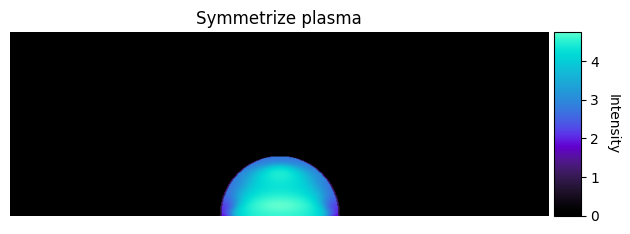

158224


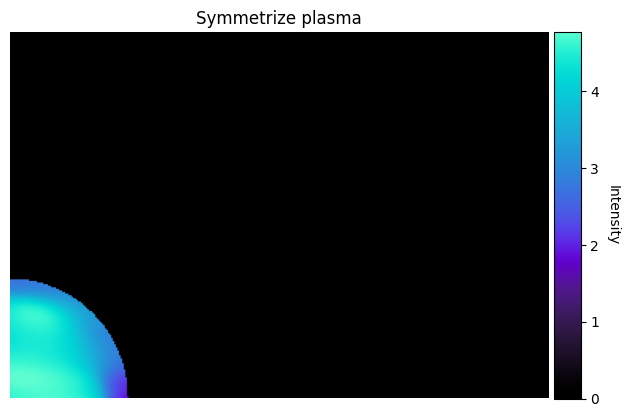

Using memory-cached basis sets


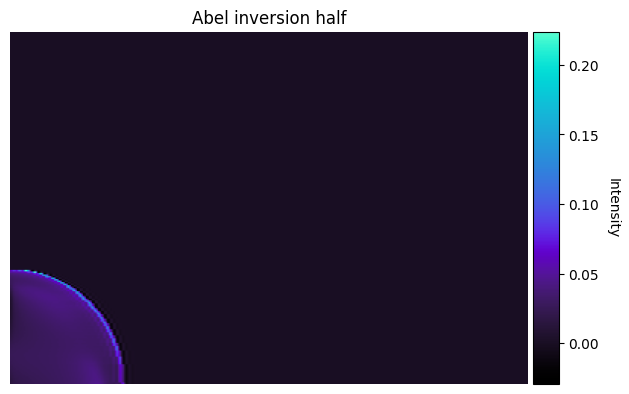

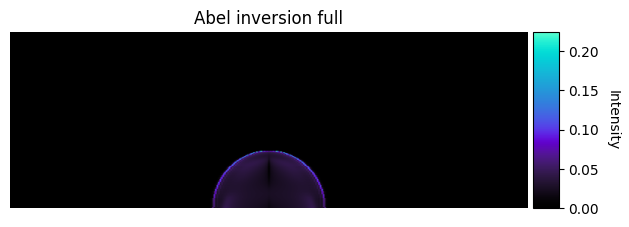

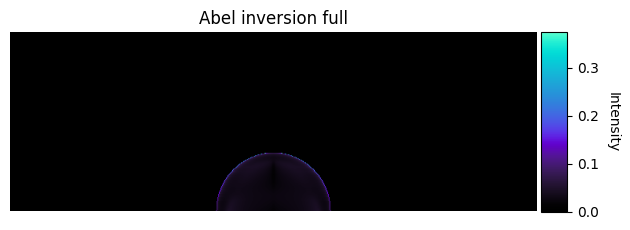

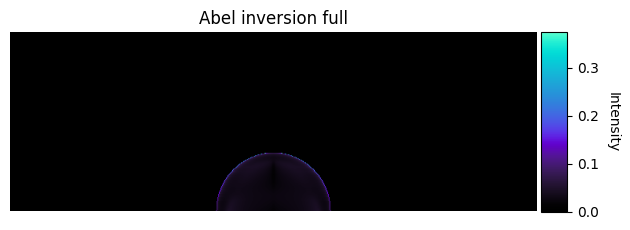

In [16]:
symmetrize_plasma = functions_abel.symmetrize_plasma_img(masked_plasma, n_rows = mask_radius_2090_H0)
global_functions_im.plot_image(symmetrize_plasma, title='Symmetrize plasma', cmap=cmr.cosmic)
print(symmetrize_plasma.size)

# Half of the image:
# a 2D m×n array: a half‐image where [:,0] is the symmetry axis
row_center = image_unwrapped.shape[1] // 2
# right side so that half[:,0] is on the axis, row_center = index column of symmetry
half_img = masked_plasma[:, row_center:]
global_functions_im.plot_image(half_img, title='Symmetrize plasma', cmap=cmr.cosmic)
# full_profile  = image_unwrapped[row_center, :].astype(float)

# Now run the inverse‐Abel on that half-profile:
dr = 1
inv_basex = functions_abel.inverse_abel(half_img, method = 'basex', dr = dr)
inv_hansenlaw = functions_abel.inverse_abel(half_img, method = 'hansenlaw', dr = dr)
global_functions_im.plot_image(inv_basex, title='Abel inversion half', cmap=cmr.cosmic)

# Mirror data:
inv_basex_full = functions_abel.mirror_image(inv_basex)
inv_hansenlaw_full = functions_abel.mirror_image(inv_hansenlaw)
global_functions_im.plot_image(inv_basex_full, title='Abel inversion full', cmap=cmr.cosmic)
global_functions_im.plot_image(inv_hansenlaw_full, title='Abel inversion full', cmap=cmr.cosmic)


"""
Attempt to mask plasma with Otsus method and gradient
"""
from skimage.filters import sobel_h, sobel_v
def compute_gradient_map(data: np.ndarray,
                         smooth_sigma: float = 1.0) -> np.ndarray:
    """
    Compute the gradient magnitude map of a two dimensional array
    using Sobel filters and optional Gaussian smoothing

    Parameters
    ----------
    data : np.ndarray
        Two dimensional array of scalar values
    smooth_sigma : float
        Standard deviation for Gaussian smoothing.
        If zero or None no smoothing is applied

    Returns
    -------
    grad : np.ndarray
        Gradient magnitude map of same shape as data
    """
    if data.ndim != 2:
        raise ValueError(f"Expected 2D array but got ndim={data.ndim}")

    # apply Gaussian smoothing if requested
    if smooth_sigma:
        img = gaussian_filter(data, sigma=smooth_sigma)
    else:
        img = data

    # compute Sobel derivatives
    gx = sobel_h(img)
    gy = sobel_v(img)

    # combine into gradient magnitude
    grad = np.hypot(gx, gy)
    return grad

gradient = compute_gradient_map(image_unwrapped, smooth_sigma = 8)
global_functions_im.plot_image(gradient, title='Phase shift', cmap=cmr.cosmic) # prinsenvlag, iceburn, redshift

1. Masking out plasma

In [13]:
"""
from abel import tools, transform

# 3 Perform inverse Abel transform with two methods
inv_basex     = transform.basex.basex_transform(image_unwrapped)
inv_hansenlaw = transform.hansenlaw.hansenlaw_transform(image_unwrapped)

# 4 Visualize original and inverted images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(image_unwrapped, cmap='gray')
axes[0].set_title('Original projection')
axes[0].axis('off')

axes[1].imshow(inv_basex, cmap=cmr.iceburn)
axes[1].set_title('Inverse Abel (BASEX)')
axes[1].axis('off')

axes[2].imshow(inv_hansenlaw, cmap=cmr.iceburn)
axes[2].set_title('Inverse Abel (Hansen–Law)')
axes[2].axis('off')

plt.tight_layout()
plt.show()
"""

"\nfrom abel import tools, transform\n\n# 3\u2003Perform inverse Abel transform with two methods\ninv_basex     = transform.basex.basex_transform(image_unwrapped)\ninv_hansenlaw = transform.hansenlaw.hansenlaw_transform(image_unwrapped)\n\n# 4\u2003Visualize original and inverted images\nfig, axes = plt.subplots(1, 3, figsize=(12, 4))\n\naxes[0].imshow(image_unwrapped, cmap='gray')\naxes[0].set_title('Original projection')\naxes[0].axis('off')\n\naxes[1].imshow(inv_basex, cmap=cmr.iceburn)\naxes[1].set_title('Inverse Abel (BASEX)')\naxes[1].axis('off')\n\naxes[2].imshow(inv_hansenlaw, cmap=cmr.iceburn)\naxes[2].set_title('Inverse Abel (Hansen–Law)')\naxes[2].axis('off')\n\nplt.tight_layout()\nplt.show()\n"